## Package required

In [4]:
from warnings import filterwarnings

filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import SelectKBest,f_classif,chi2
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import numpy as np
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
X_train=pd.read_table("ada_train.data",delim_whitespace=True,header=None)
X_valid=pd.read_table("ada_valid.data",delim_whitespace=True,header=None)
X_test=pd.read_table("ada_test.data",delim_whitespace=True,header=None)


y_train=pd.read_table("ada_train.labels",delim_whitespace=True,header=None)
y_valid=pd.read_table("ada_valid.labels",delim_whitespace=True,header=None)


Column_train={"X"+str(i):X_train.iloc[:,i-1] for i in range(1,X_train.shape[1]+1)}
Column_valid={"X"+str(i):X_valid.iloc[:,i-1] for i in range(1,X_valid.shape[1]+1)}
Column_test={"X"+str(i):X_test.iloc[:,i-1] for i in range(1,X_test.shape[1]+1)}


In [7]:
ada_train_data=pd.DataFrame(Column_train)
ada_valid_data=pd.DataFrame(Column_valid)
ada_test_data=pd.DataFrame(Column_test)

ada_train_label=pd.DataFrame({"target":y_train.iloc[:,0]})
ada_valid_label=pd.DataFrame({"target":y_valid.iloc[:,0]})

In [8]:
ada_train_data.shape,ada_valid_data.shape,ada_test_data.shape

((4147, 48), (415, 48), (41471, 48))

In [9]:
ada_train_label.shape,ada_valid_label.shape

((4147, 1), (415, 1))

In [10]:
### Check for NaN

ada_train_data.isna().any().sum(),ada_valid_data.isna().any().sum(),ada_test_data.isna().any().sum()

(0, 0, 0)

There are no NaN values in our data

In [11]:
### Data types

numerical_cols=ada_train_data.columns[ada_train_data.nunique()>2]
categorical_cols=ada_train_data.columns[ada_train_data.nunique()<=2]

In [12]:
### Get descriptive statistics from numerical data

ada_train_data[numerical_cols].describe()

,X4,X10,X15,X25,X32,X40
count,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000
mean,126.408006,20.033036,631.886665,429.348686,10.964070,411.804196
std,69.754074,91.933304,161.410107,146.029831,76.318757,119.999993
min,13.000000,0.000000,62.000000,189.000000,0.000000,10.000000
25%,78.500000,0.000000,562.000000,311.000000,0.000000,404.000000
50%,119.000000,0.000000,624.000000,411.000000,0.000000,404.000000
75%,160.000000,0.000000,812.000000,522.000000,0.000000,454.000000
max,995.000000,648.000000,999.000000,999.000000,999.000000,999.000000


<AxesSubplot: >

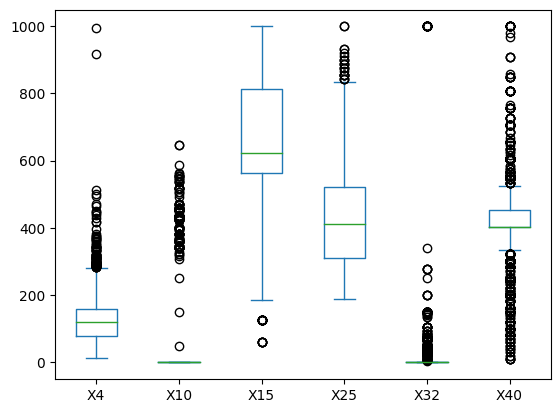

In [13]:
ada_train_data[numerical_cols].plot(kind="box")

Evidently we are facing 

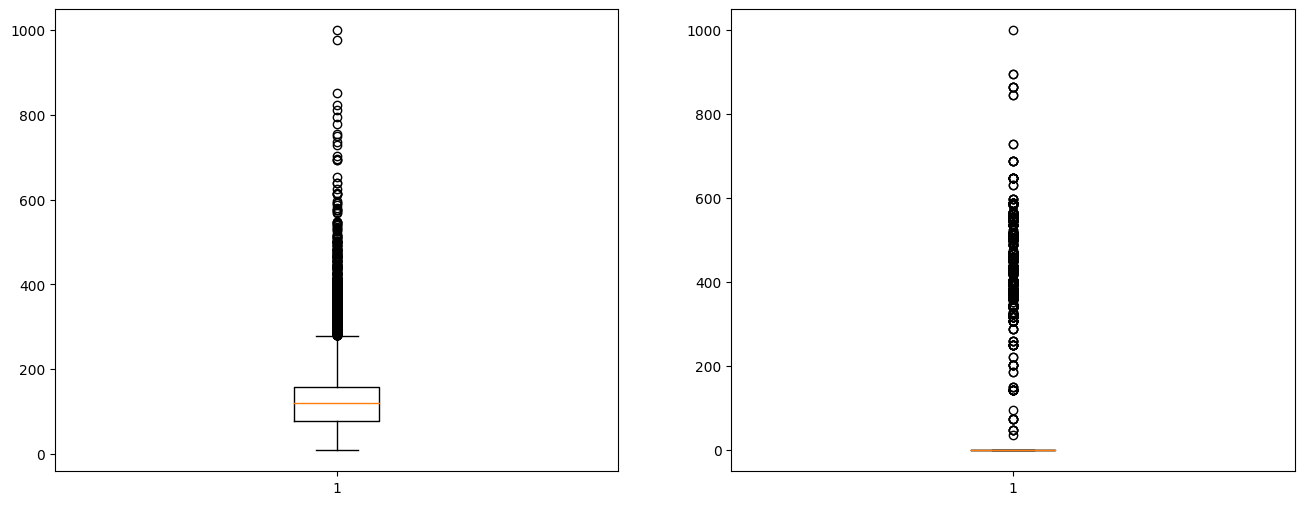

In [14]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[0]])
axs[1].boxplot(ada_test_data[numerical_cols[1]])
plt.show()

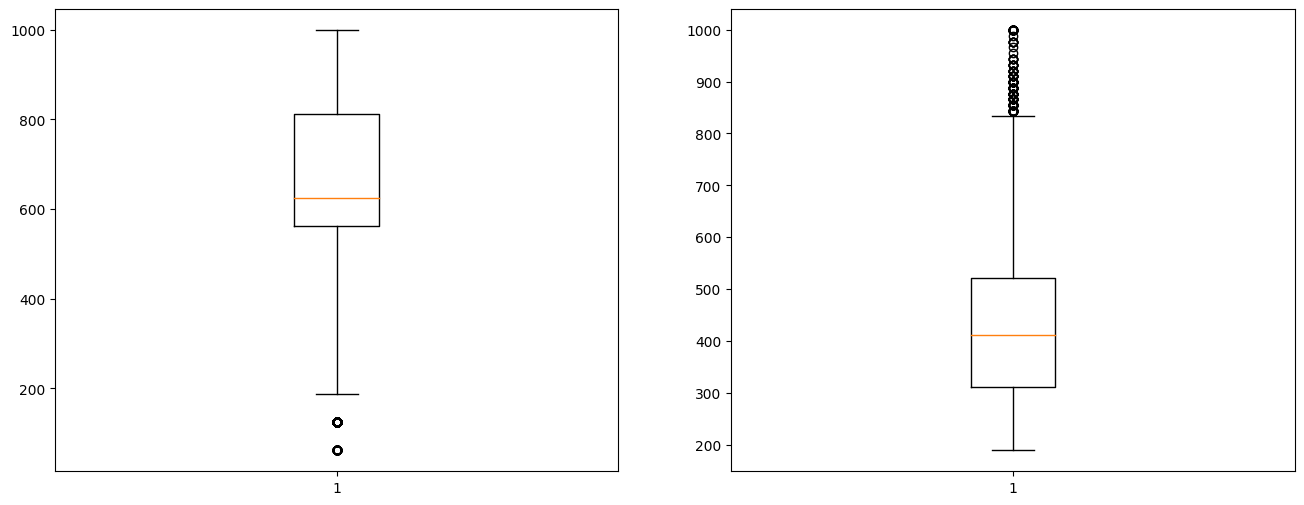

In [15]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[2]])
axs[1].boxplot(ada_test_data[numerical_cols[3]])
plt.show()

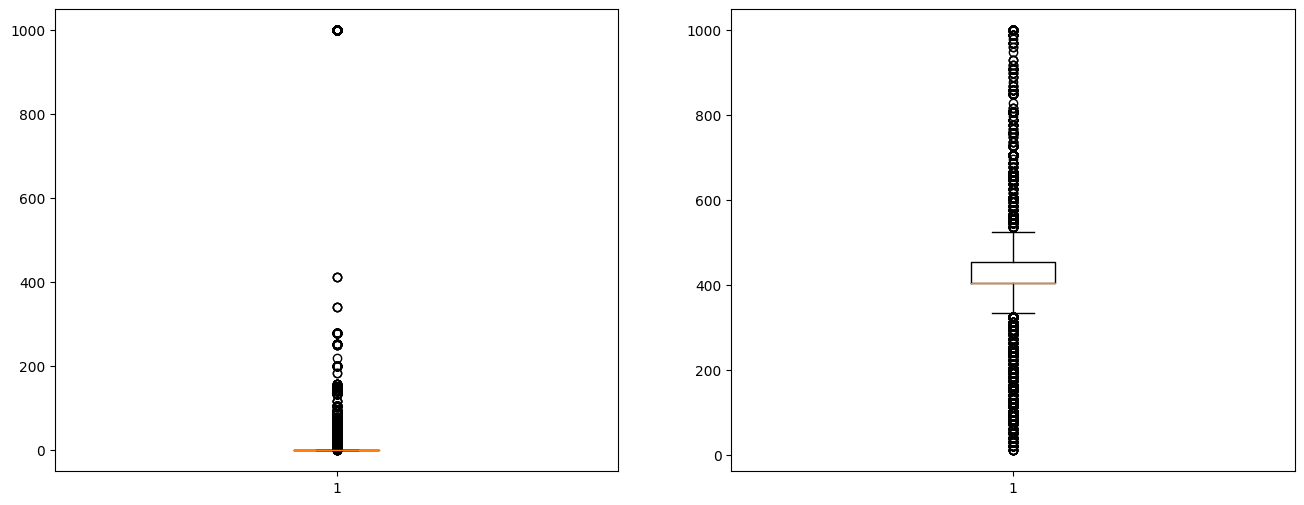

In [16]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[4]])
axs[1].boxplot(ada_test_data[numerical_cols[5]])
plt.show()

### Outlier handling

According to the expert of data, outliers is the bigest problem that can introduce biais in analysis and hide generally tendancy most of time especially when data size is small.

There many scenarios that can worthy and very bad but there not pre-defined strategies to get directly the best strategies to handle outliers. Even if, we have this problem; according to problematic some strategies will be more useful than others.

- Filtered test data set to avoid outliers
- 

In [17]:
ada_train_data.nunique().max(),ada_train_data.nunique().min()

(330, 1)

In [18]:
ada_train_data.X21.unique(),ada_valid_data.X21.unique(),ada_test_data.X21.unique()

(array([0]), array([0]), array([0]))

In [19]:
#The column contains just a unique value then it's not useful for discrimination

ada_train_data=ada_train_data.drop(columns=['X21'])
ada_valid_data=ada_valid_data.drop(columns=['X21'])
ada_test_data=ada_test_data.drop(columns=['X21'])

In [20]:
def get_percentage_of_outlier(df):

    numerical_cols=df.columns[df.nunique()>2]
    
    n=df.shape[0]

    outlier_size={}
 
    for col in numerical_cols:

        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        IQR=q3-q1

        outliers_shape=df[(df[col]<q1-1.5*IQR)].shape[0] + df[(df[col]>q3+1.5*IQR)].shape[0]

        outlier_size[col]=outliers_shape

    return outlier_size

In [21]:
get_percentage_of_outlier(ada_train_data)

{'X4': 98, 'X10': 193, 'X15': 25, 'X25': 24, 'X32': 336, 'X40': 1108}

### Modelisation

In [22]:
Classifiers=[KNeighborsClassifier,
             LogisticRegression,
             DecisionTreeClassifier,
             GaussianNB,
             LinearDiscriminantAnalysis]

In [23]:
ada_train_data.shape,ada_train_label.shape

((4147, 47), (4147, 1))

#### Before outlier handling

In [24]:
### Data Normalisation

def normalize_num_cols(df):

    df_standard=df.copy()

    standardizing=StandardScaler()
    
    numerical_cols=df.columns[df.nunique()>2]

    standar_col_num=standardizing.fit_transform(df[numerical_cols])

    df_standard[numerical_cols]=standar_col_num

    return df_standard

In [25]:
def get_accuray(train_set,train_label,valid_set,valid_label,cv=50):

    col=["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]
    df=pd.DataFrame(columns=col)
    for classifier in Classifiers:
        Name=classifier.__name__
        model=classifier().fit(train_set,train_label)
        y_pred=model.predict(valid_set)
        acc=np.mean(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER=np.mean(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC=np.mean(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))

        acc_std=np.std(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER_std=np.std(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC_std=np.std(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))
        #acc=metrics.accuracy_score(valid_label,y_pred)
        #BER=metrics.balanced_accuracy_score(valid_label,y_pred)
        #ROC=metrics.roc_auc_score(valid_label,y_pred)

        df1=pd.DataFrame([[Name,acc,BER,ROC,acc_std,BER_std,ROC_std]],columns=col)
        df=df.append(df1)

    return df

In [26]:
accuracy_df=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [27]:
### For normalized data

ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

#### After handling

In [28]:
from sklearn.impute import KNNImputer

def replace_outlier(x,min_whisker,max_whisker):

    if x<min_whisker or x>max_whisker:

        x=np.NaN
    
    return x


def fill_outlier(df_ada,method):

    numerical_cols=df_ada.columns[df_ada.nunique()>2]
 
    for col in numerical_cols:

        q1=df_ada[col].quantile(0.25)
        
        q3=df_ada[col].quantile(0.75)

        IQR=q3-q1

        min_whisker=q1-1.5*IQR
        max_whisker=q3+1.5*IQR

        df_ada[col]=df_ada[col].apply(lambda x: replace_outlier(x,min_whisker,max_whisker))

    if method=="mean":
            
        df_ada=df_ada.fillna(df_ada.mean())
        
    if method=="knn":
            
        imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

        df_ada[numerical_cols]=imputer.fit_transform(df_ada[numerical_cols])
    
    return df_ada

In [29]:
ada_train_data=fill_outlier(ada_train_data,method="knn")
ada_valid_data=fill_outlier(ada_valid_data,method="knn")

accuracy_df_outlier_trim=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [30]:
ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_outlier_trim_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

In [31]:
accuracy_df["data"]="raw"
accuracy_df_stand["data"]="raw_standard"
accuracy_df_outlier_trim["data"]="outlier_trimmed by mean"
accuracy_df_outlier_trim_stand["data"]="outlier_trimmed by mean and standard"

accuracies=[accuracy_df,accuracy_df_stand,accuracy_df_outlier_trim,accuracy_df_outlier_trim_stand]

accuracies_df=pd.concat(accuracies)

In [32]:
accuracies_df.sort_values(by=["Accuracy_mean","BER_mean","ROC_mean"],ascending=False)

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std,data
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259,raw_standard
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw_standard
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802,raw_standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean and standard
0,LogisticRegression,0.833864,0.746569,0.886386,0.038389,0.054891,0.039575,outlier_trimmed by mean and standard
0,LogisticRegression,0.831699,0.748389,0.882397,0.037602,0.056776,0.044011,raw
0,LogisticRegression,0.829518,0.740042,0.874568,0.034999,0.052856,0.042384,outlier_trimmed by mean
0,KNeighborsClassifier,0.815783,0.749339,0.843623,0.041793,0.052984,0.049040,outlier_trimmed by mean and standard


We find that the best model is build with standardized row data without outlier trimmed

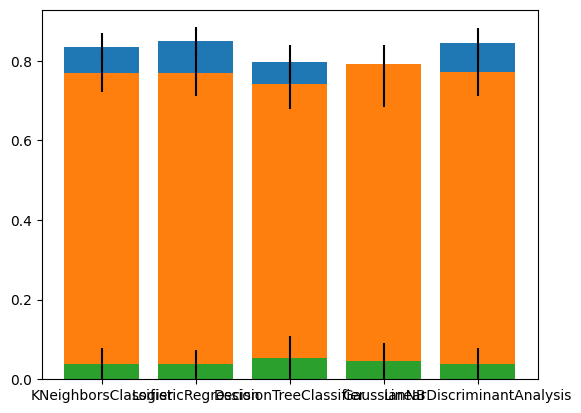

In [33]:
error_df=accuracies_df[accuracies_df["data"]=="raw_standard"][["Name","Accuracy_mean",\
    "BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]]
    #.plot(kind="bar",x="Name",yerr=,figsize=(16,6))

plt.bar(error_df.Name,error_df["Accuracy_mean"],yerr=error_df.Accuracy_std)
plt.bar(error_df.Name,error_df["BER_mean"],yerr=error_df.BER_std)
plt.bar(error_df.Name,error_df["ROC_std"],yerr=error_df.ROC_std)
plt.show()

In [34]:
error_df

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259
0,DecisionTreeClassifier,0.797179,0.741554,0.741006,0.041903,0.061893,0.054354
0,GaussianNB,0.734508,0.791993,0.874911,0.049496,0.046691,0.045471
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917


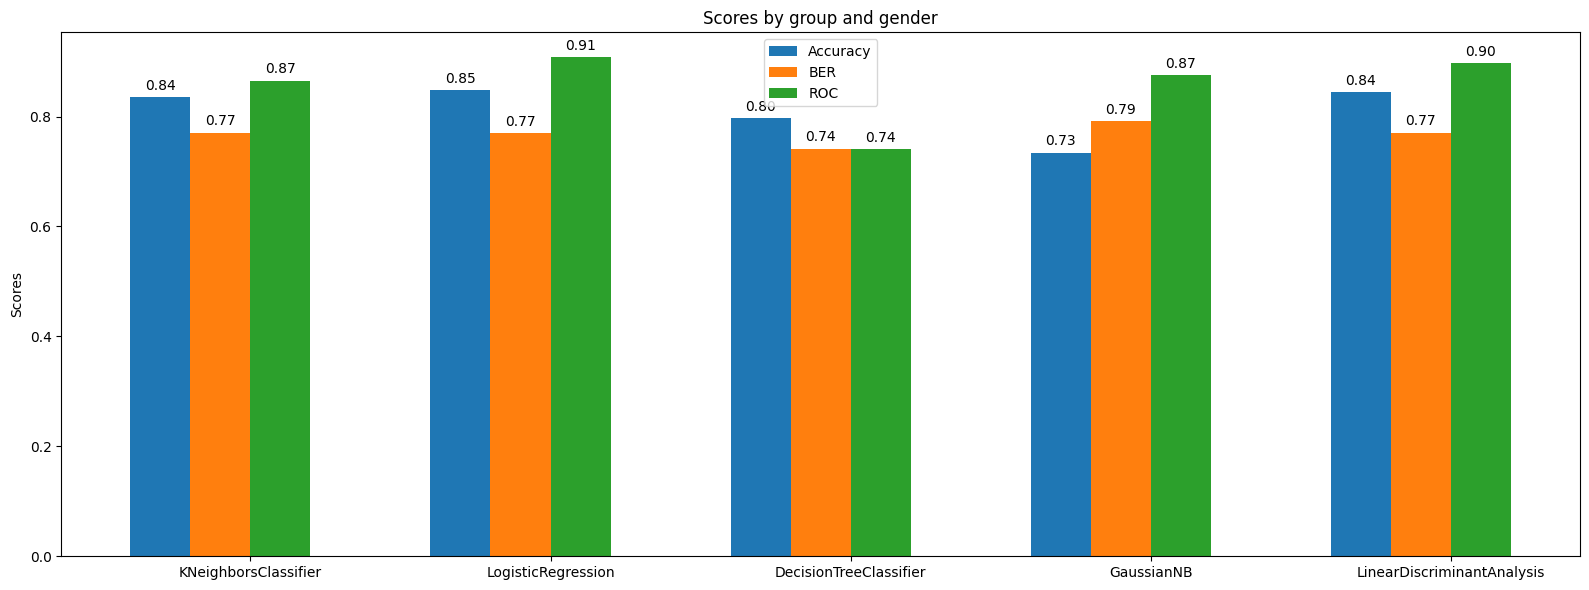

In [35]:
ind = np.arange(error_df["Accuracy_mean"].shape[0])  # the x locations for the groups
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind - 1.5*width, error_df["Accuracy_mean"], width, #yerr=error_df["Accuracy_std"],
                label='Accuracy')
rects2 = ax.bar(ind -0.5*width, error_df["BER_mean"], width, #yerr=error_df["BER_std"],
                label='BER')

rects3 = ax.bar(ind +0.5*width, error_df["ROC_mean"], width, #yerr=error_df["ROC_std"],
                label='ROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(error_df["Name"])
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    i=0
    for rect in rects:

        height = rect.get_height()

        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        i+=1

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()

plt.show()

In [36]:
error_df.Name

0          KNeighborsClassifier
0            LogisticRegression
0        DecisionTreeClassifier
0                    GaussianNB
0    LinearDiscriminantAnalysis
Name: Name, dtype: object

In [37]:
error_df["Name"]=error_df["Name"].replace("KNeighborsClassifier","KNN")
error_df["Name"]=error_df["Name"].replace("LogisticRegression","LR")
error_df["Name"]=error_df["Name"].replace("DecisionTreeClassifier","DT")
error_df["Name"]=error_df["Name"].replace("GaussianNB","Bayes")
error_df["Name"]=error_df["Name"].replace("LinearDiscriminantAnalysis","LDA")

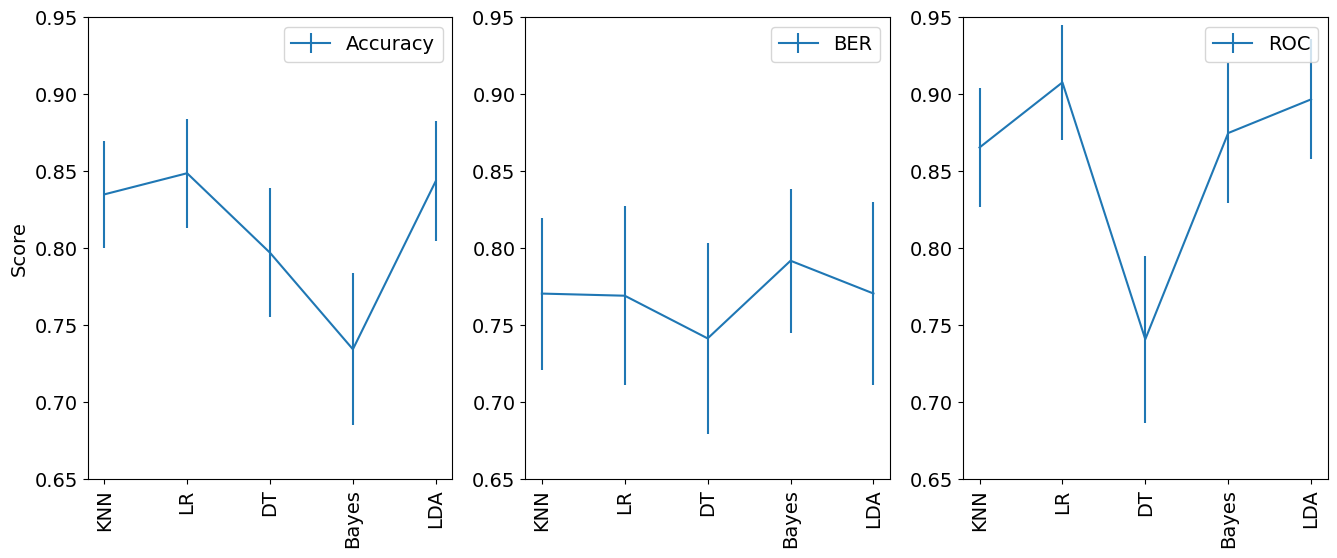

In [38]:

plt.rcParams.update({"font.size":14})
fig,axs=plt.subplots(ncols=3,figsize=(16,6))

axs[0].errorbar(error_df["Name"],error_df["Accuracy_mean"],error_df["Accuracy_std"],label="Accuracy")
axs[1].errorbar(error_df["Name"],error_df["BER_mean"],error_df["BER_std"],label="BER")
axs[2].errorbar(error_df["Name"],error_df["ROC_mean"],error_df["ROC_std"],label="ROC")

axs[0].set_ylabel("Score")

axs[0].set_ylim(0.65,0.95)
axs[1].set_ylim(0.65,0.95)
axs[2].set_ylim(0.65,0.95)

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_xticklabels(error_df["Name"],rotation=90)
axs[1].set_xticklabels(error_df["Name"],rotation=90)
axs[2].set_xticklabels(error_df["Name"],rotation=90)

plt.show()

### Feature selection

In [39]:
import time

def attribute_impact(models,X,y,n_attributes_in_range):
    
        scores_means={}
        scores_stds={}
        times={}
        
        
        for name,model in zip(models.keys(),models.values()):
            
            #train_scores,test_scores=initiate_dict(models)

            #train_scores[name]=[]
            
            check_mean={"Accuracy_mean":[],"BER_mean":[],"ROC_mean":[]}
            check_std={"Accuracy_std":[],"BER_std":[],"ROC_std":[]}
            time_dict={}

            for num_attributes in n_attributes_in_range:

                #Intialisation de la méthode de selection

                selector=SelectKBest(score_func=f_classif, k=num_attributes)

                # Entrainnement de la méthode
                selector_fitted=selector.fit(X,y)

                # Récuperation des variables sélectionnées
                columns=X.columns[selector.get_support()]

                #test_scores[name]=check
                
                start_time=time.time()

                score_accuracy=cross_val_score(model,X[columns],y,cv=30,scoring='accuracy',n_jobs=-1)
                score_ber=cross_val_score(model,X[columns],y,cv=30,scoring='balanced_accuracy',n_jobs=-1)
                score_roc=cross_val_score(model,X[columns],y,cv=30,scoring='roc_auc',n_jobs=-1)
                
                end_time=time.time()

                time_dict[num_attributes]=end_time-start_time

                #Testing score
                #Accuracy
                check_mean["Accuracy_mean"].append(np.mean(score_accuracy))
                check_std["Accuracy_std"].append(np.std(score_accuracy))

                #Presicion
                check_mean["BER_mean"].append(np.mean(score_ber))
                check_std["BER_std"].append(np.std(score_ber))


                #Recall
                check_mean["ROC_mean"].append(np.mean(score_roc))
                check_std["ROC_std"].append(np.std(score_roc))

            scores_means[name]=check_mean
            scores_stds[name]=check_std
            times[name]=time_dict
                
        return scores_means,scores_stds,times

In [42]:
ada_train_label.head()

,target
0,-1
1,-1
2,-1
3,1
4,-1


In [43]:
models={"bayes":GaussianNB(),"LR":LogisticRegression(),"LDA":LinearDiscriminantAnalysis()\
    ,"DT":DecisionTreeClassifier(),"KNN":KNeighborsClassifier()}
n_attributes_in_range=range(1,len(ada_train_data.columns)+1)
scores_means_attr,scores_std_attr,times=attribute_impact(models,ada_train_data,ada_train_label.target,n_attributes_in_range=n_attributes_in_range)

/home/criuser/.pyenv/versions/3.9.14/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/criuser/.pyenv/versions/3.9.14/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

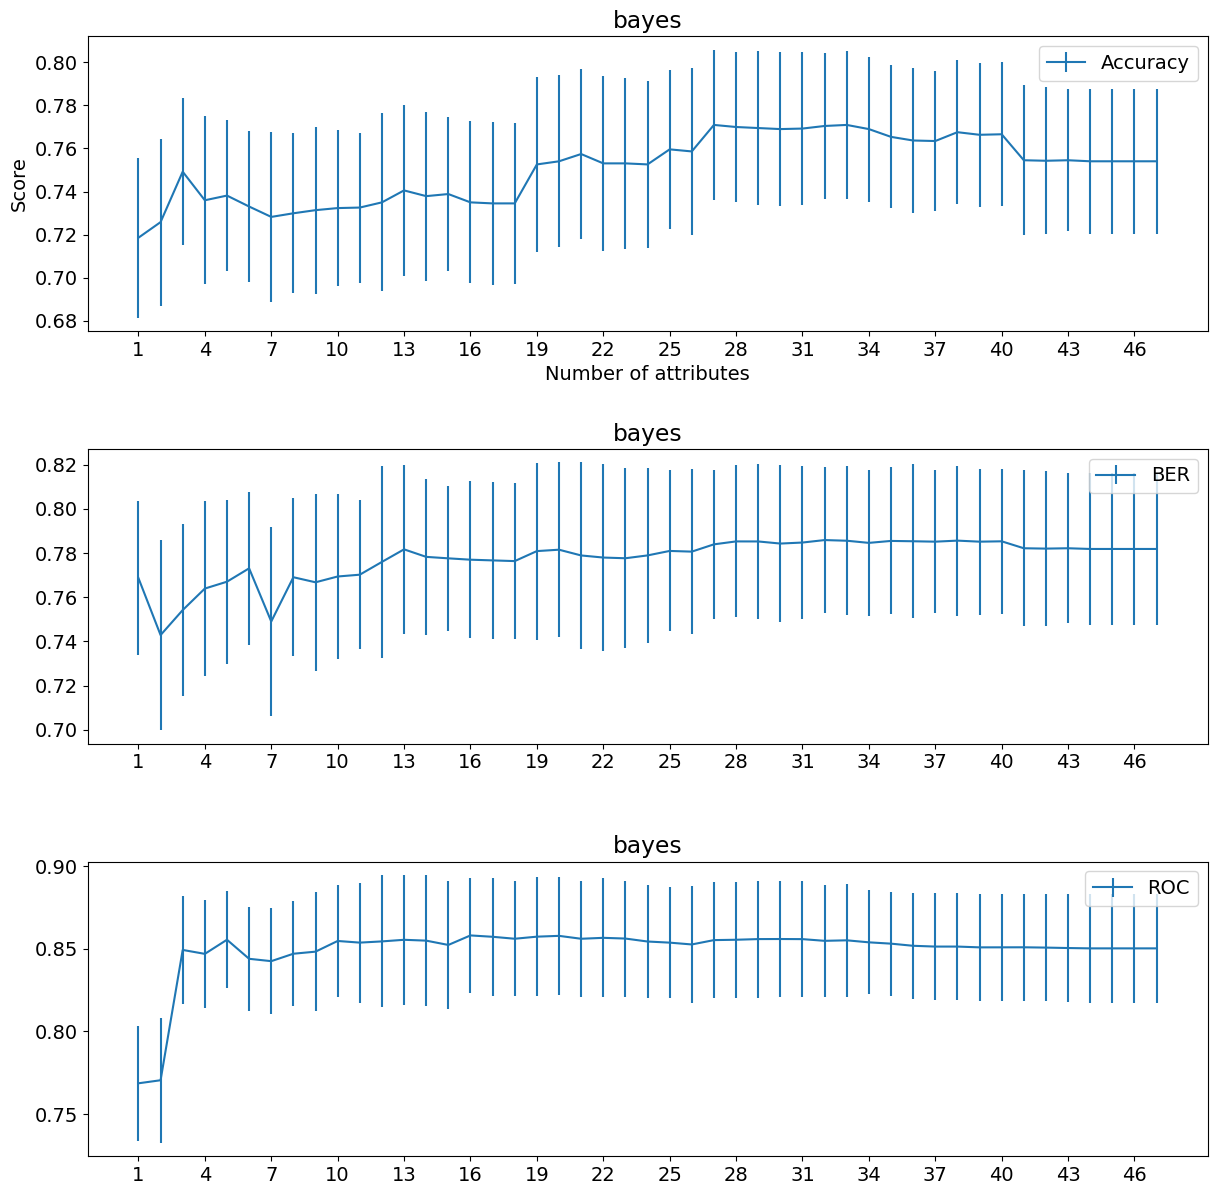

In [49]:
plt.rcParams.update({'font.size':14})

fig,axes=plt.subplots(nrows=3,figsize=(14,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

axes[0].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["Accuracy_mean"],scores_std_attr["bayes"]["Accuracy_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["BER_mean"],scores_std_attr["bayes"]["BER_std"],label="BER")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["ROC_mean"],scores_std_attr["bayes"]["ROC_std"],label="ROC")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("bayes")
axes[1].set_title("bayes")
axes[2].set_title("bayes")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))

plt.show()

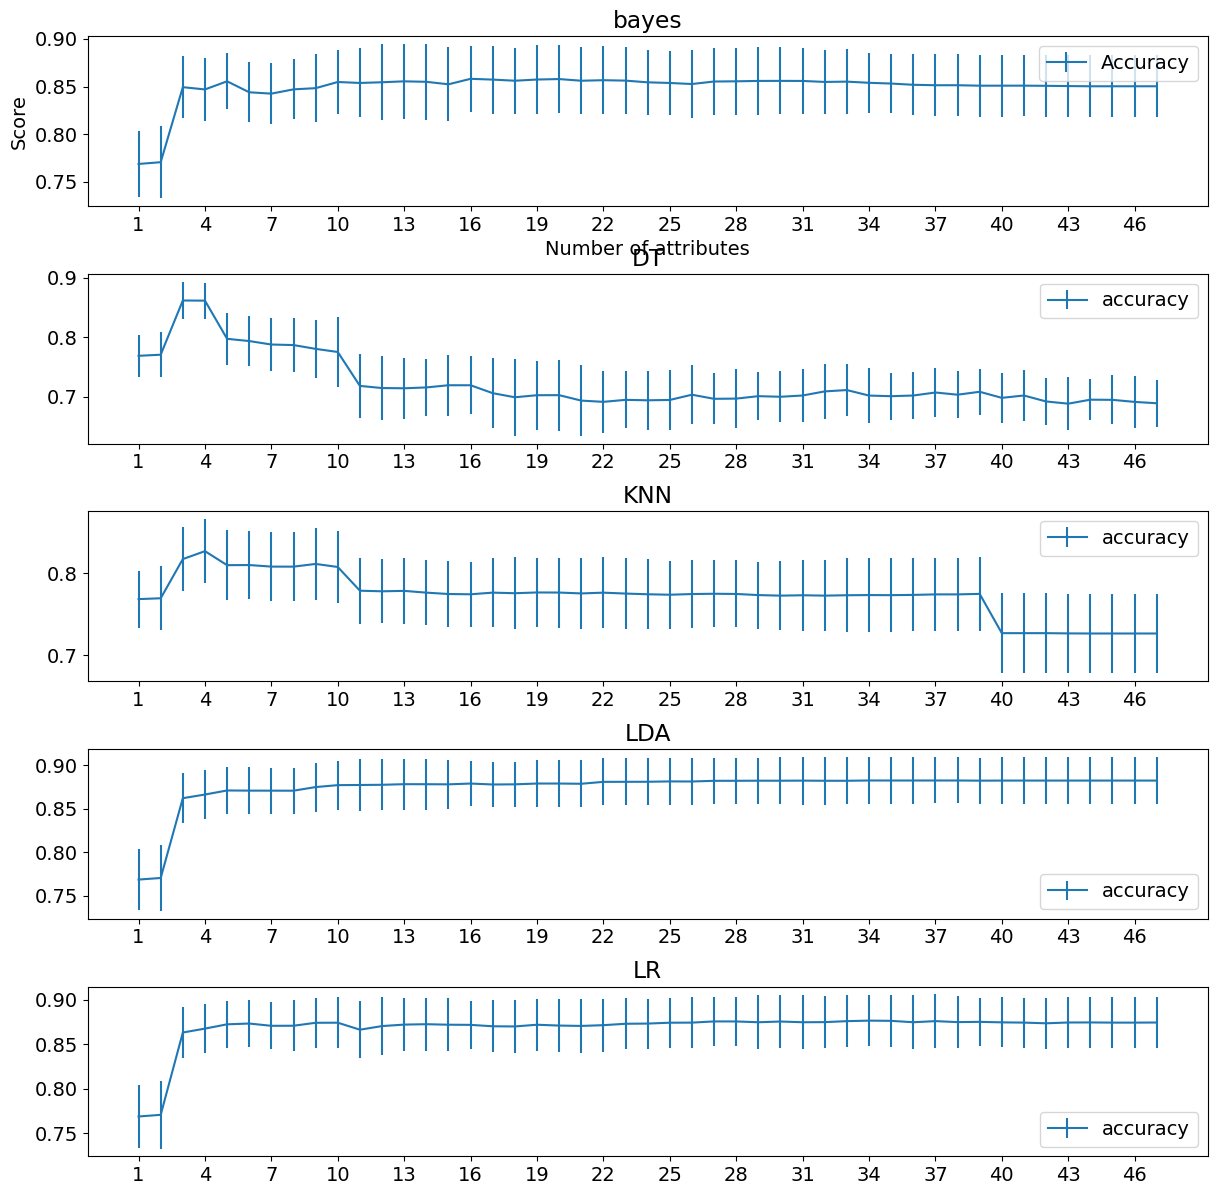

In [55]:
plt.rcParams.update({'font.size':14})

fig,axes=plt.subplots(nrows=5,figsize=(14,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

axes[0].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["ROC_mean"],scores_std_attr["bayes"]["ROC_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["DT"]["ROC_mean"],scores_std_attr["DT"]["ROC_std"],label="accuracy")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["KNN"]["ROC_mean"],scores_std_attr["KNN"]["ROC_std"],label="accuracy")
axes[3].errorbar(n_attributes_in_range,scores_means_attr["LDA"]["ROC_mean"],scores_std_attr["LDA"]["ROC_std"],label="accuracy")
axes[4].errorbar(n_attributes_in_range,scores_means_attr["LR"]["ROC_mean"],scores_std_attr["LR"]["ROC_std"],label="accuracy")


axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("bayes")
axes[1].set_title("DT")
axes[2].set_title("KNN")
axes[3].set_title("LDA")
axes[4].set_title("LR")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[3].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[4].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))


plt.show()

#### Number of attributes

Acc-----------bayes:8, DT:4,KNN:5, LDA:10,LR:12 \
BER-----------bayes:28, DT:4,KNN:3, LDA:10,LR:12\
ROC-----------bayes:5, DT:4,KNN:4, LDA:10,LR:5

### Optimisation

In [ ]:
from grid_search_useful_tools import plot_grid_search,table_grid_search